In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import sklearn

import scipy.signal as signal
import scipy.fft as fft
import soundfile as sf
import librosa as lrs

import matplotlib.pyplot as plt

### Data Processing

In [3]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

def flatten(l):
    return [item for sublist in l for item in sublist]

def separate_strokes(onsets):
    ind = []
    for i in range(len(onsets)-1):
        if(onsets[i+1] - onsets[i] > 0.03):
            ind.append(i)
            ind.append(i+1)
    ind = np.unique(ind)
    temp = onsets[ind]
    return temp,ind

def find_doublets(onsets):
    ind = []
    for i in range(len(onsets)-1):
        if(onsets[i+1] - onsets[i] <= 0.03):
            ind.append(i)
            ind.append(i+1)
    ind = np.unique(ind)
    temp = onsets[ind]
    return temp

def remove_strokes(doublets, comp_onsets):
    ind = []
    for i in range(len(comp_onsets)):
        for j in range(len(doublets)):
            if(np.abs(comp_onsets[i] - doublets[j]) <= 0.01):
                ind.append(i)
    ind = np.unique(np.array(ind))
    return np.delete(comp_onsets, ind)

def doublet_class_gen(annot_onsets, annot_labels):
    data = []
    labels = []
    i = 0
    while i <= (len(annot_onsets)-2):
        if(np.abs(annot_onsets[i+1] - annot_onsets[i]) < 0.03):
            data.append(np.mean([annot_onsets[i+1],annot_onsets[i]]))
            labels.append(5)
            i += 2
        else:
            data.append(annot_onsets[i])
            labels.append(annot_labels[i])
            i += 1
    data.append(annot_onsets[-1])
    labels.append(annot_labels[-1])
    return np.array(data),np.array(labels)

def tran_prob(onset_labels):
    probs = np.zeros((6,6))
    for i in range(1,len(onset_labels)):
        curr = onset_labels[i]
        prev = onset_labels[i-1]
        probs[curr,prev] += 1
    return probs

In [4]:
# Define all required directories and filepaths
master_dir = r"/content/drive/My Drive/Colab Notebooks/Stroke_Classification_Data_PitchShifted"
files = os.listdir(master_dir)
# num_comp = len(files) // 8 # (or 10) 3 (or 5) audio files + 5 annotation files per composition
num_comp = 5
num_audio = 3
num_files = num_audio + 5
files = np.sort(np.array(files))
files = files.tolist()

In [5]:
# files = files[16:46]

In [6]:
# Extract audio and annotation data
# Convert annotation data into one-hot encoded vectors
# Compute onset times and label appropriately

audio_data = []
annot_onsets = []
annot_labels = []
comp_onsets = []
comp_onset_labels = []
mag_spectra = []
probs = np.zeros((6,6))
fs = 48000
freqs = fft.fftfreq(fs, 1/fs)

for i in range(num_comp):
    for j in range(num_files*i, num_files*i + num_audio):

        filepath = os.path.join(master_dir, files[j])
        print(files[j])
        data, fs = sf.read(filepath)
        mono_data = data[:,0] + data[:,1]
        audio_data.append(mono_data)

        annot_data_tmp = []
        annot_onsets_tmp = []
        annot_labels_tmp = []
        for z in range(num_files*i + num_audio, num_files*i + num_audio + 5):
            filepath = os.path.join(master_dir, files[z])
            print(files[z])
            tmp = pd.read_csv(filepath, header=None)
            annot_data_tmp.append(tmp)
            
        count = 0
        for k in annot_data_tmp:
            for l in k[0]:
                annot_onsets_tmp.append(l)
                annot_labels_tmp.append(count)
            count += 1
        annot_onsets_tmp = np.array(annot_onsets_tmp)
        annot_labels_tmp = np.array(annot_labels_tmp)
        sorted_args = np.argsort(annot_onsets_tmp)
        annot_onsets_tmp = annot_onsets_tmp[sorted_args]
        annot_labels_tmp = annot_labels_tmp[sorted_args]

        annot_onsets_tmp,annot_labels_tmp = doublet_class_gen(annot_onsets_tmp,annot_labels_tmp)
        # probs = probs + tran_prob(annot_labels_tmp)
        annot_labels_tmp = one_hot(annot_labels_tmp, 6)
        annot_onsets.append(annot_onsets_tmp)
        annot_labels.append(annot_labels_tmp)
        
        onset_times = lrs.onset.onset_detect(y=mono_data, sr=fs, hop_length=120, units='time', backtrack=False)
        onset_labels = []
        for p in onset_times:
            tmp = np.argmin(np.abs(annot_onsets_tmp - p))
            onset_labels.append(annot_labels_tmp[tmp])
        comp_onsets.append(onset_times)
        comp_onset_labels.append(np.array(onset_labels))
        
        spectra_tmp = []
        mag_spectra_tmp = []
        onset_samples = np.rint(onset_times*fs).astype('int32')

        tmp1 = onset_samples[0] - 2*fs//100
        tmp2 = onset_samples[0] + (onset_samples[1]-onset_samples[0])//2
        spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
        mag_spectra_tmp.append(np.abs(spectra_tmp[0]))

        for m in range(1,len(onset_times)-1):
            tmp1 = onset_samples[m] - 2*fs//100
            tmp2 = onset_samples[m] + (onset_samples[m+1]-onset_samples[m])//2
            spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
            mag_spectra_tmp.append(np.abs(spectra_tmp[m]))

        tmp1 = onset_samples[m+1] - 2*fs//100
        tmp2 = onset_samples[m+1] + 5*fs//100
        spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
        mag_spectra_tmp.append(np.abs(spectra_tmp[m+1]))

        mag_spectra.append(mag_spectra_tmp)

mag_spectra = np.array(flatten(mag_spectra))
comp_onset_labels = np.array(flatten(comp_onset_labels))

T102KhandaGrooveMri.wav
T102_hi.csv
T102_lo.csv
T102_mid_1.csv
T102_mid_2.csv
T102_mid_3.csv
T102KhandaGrooveMri_OneSemiHigher.wav
T102_hi.csv
T102_lo.csv
T102_mid_1.csv
T102_mid_2.csv
T102_mid_3.csv
T102KhandaGrooveMri_OneSemiLower.wav
T102_hi.csv
T102_lo.csv
T102_mid_1.csv
T102_mid_2.csv
T102_mid_3.csv
T127AdiComp5Mri85bpm.wav
T127_hi.csv
T127_lo.csv
T127_mid_1.csv
T127_mid_2.csv
T127_mid_3.csv
T127AdiComp5Mri85bpm_OneSemiHigher.wav
T127_hi.csv
T127_lo.csv
T127_mid_1.csv
T127_mid_2.csv
T127_mid_3.csv
T127AdiComp5Mri85bpm_OneSemiLower.wav
T127_hi.csv
T127_lo.csv
T127_mid_1.csv
T127_mid_2.csv
T127_mid_3.csv
T25AdiComp1Mri70bpm.wav
T25_hi.csv
T25_lo.csv
T25_mid_1.csv
T25_mid_2.csv
T25_mid_3.csv
T25AdiComp1Mri70bpm_OneSemiHigher.wav
T25_hi.csv
T25_lo.csv
T25_mid_1.csv
T25_mid_2.csv
T25_mid_3.csv
T25AdiComp1Mri70bpm_OneSemiLower.wav
T25_hi.csv
T25_lo.csv
T25_mid_1.csv
T25_mid_2.csv
T25_mid_3.csv
T26AdiComp1Mri85bpm.wav
T26_hi.csv
T26_lo.csv
T26_mid_1.csv
T26_mid_2.csv
T26_mid_3.csv
T26Adi

In [7]:
del audio_data
del annot_onsets
del comp_onsets
# del spectra

### Neural Net Classifier Training and Testing

In [8]:
def build_model():
    initializer = keras.initializers.HeNormal()
    inputs = keras.Input(shape =(12000,))
    x = layers.Dense(15000, 'relu', kernel_initializer=initializer)(inputs)
    x = keras.layers.Dropout(0.3)(x)
    x = layers.Dense(9000, 'relu', kernel_initializer=initializer)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = layers.Dense(4500, 'relu', kernel_initializer=initializer)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = layers.Dense(1500, 'relu', kernel_initializer=initializer)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = layers.Dense(450, 'relu', kernel_initializer=initializer)(x)
    x = layers.Dense(100, 'relu', kernel_initializer=initializer)(x)
    outputs = layers.Dense(6, activation = 'softmax')(x)
    
    
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'stroke_transcription_ann')
    model.compile(loss=keras.losses.CategoricalCrossentropy(), 
                  optimizer = keras.optimizers.Adam(learning_rate=0.0002),
                  metrics='accuracy')
    
    return model

In [9]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print(' ')
        print('.', end = '')
        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Crossentropy")
    plt.plot(hist['epoch'], hist['loss'], label = "Training CCE")
    plt.plot(hist['epoch'], hist['val_loss'], label = "Validation CCE")
    plt.legend()
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(hist['epoch'], hist['accuracy'], label = "Training Accuracy")
    plt.plot(hist['epoch'], hist['val_accuracy'], label = "Validation Accuracy")
    plt.legend()

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='max', restore_best_weights=True)

In [10]:
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(
                                                   mag_spectra, comp_onset_labels,
                                                   test_size=0.15, stratify=comp_onset_labels)

In [11]:
# del mag_spectra
# del comp_onset_labels

Epoch 1/25
138/138 [==============================] - 18s 111ms/step - loss: 3.0293 - accuracy: 0.5122 - val_loss: 0.9586 - val_accuracy: 0.7018
Epoch 2/25
138/138 [==============================] - 13s 97ms/step - loss: 0.9394 - accuracy: 0.6944 - val_loss: 0.8181 - val_accuracy: 0.7603
Epoch 3/25
138/138 [==============================] - 13s 97ms/step - loss: 0.8014 - accuracy: 0.7558 - val_loss: 0.7245 - val_accuracy: 0.7873
Epoch 4/25
138/138 [==============================] - 14s 99ms/step - loss: 0.7517 - accuracy: 0.7678 - val_loss: 0.6692 - val_accuracy: 0.8130
Epoch 5/25
138/138 [==============================] - 13s 92ms/step - loss: 0.6985 - accuracy: 0.7914 - val_loss: 0.6563 - val_accuracy: 0.8091
Epoch 6/25
138/138 [==============================] - 13s 92ms/step - loss: 0.6629 - accuracy: 0.8006 - val_loss: 0.6723 - val_accuracy: 0.8033
Epoch 7/25
138/138 [==============================] - 13s 97ms/step - loss: 0.6159 - accuracy: 0.8111 - val_loss: 0.6165 - val_accuracy

[0.6164869666099548, 0.8251928091049194]

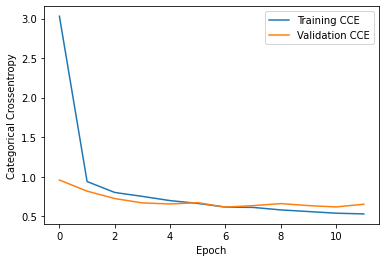

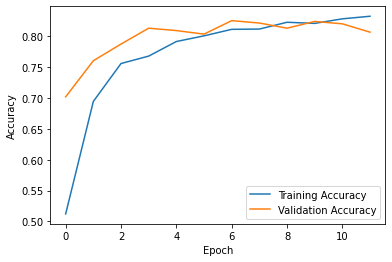

In [12]:
epochs = 25
meow = build_model()
history = meow.fit(train_data, train_labels, validation_data=(test_data,test_labels), epochs=epochs, batch_size=64, 
                   verbose=1, callbacks=[early_stop])
plot_history(history)
meow.evaluate(test_data, test_labels)

In [13]:
# meow.save('/content/drive/My Drive/Colab Notebooks/saved_meow_8236acc_6class')

### Markov Model Incorporation

In [16]:
master_dir = r"/content/drive/My Drive/Colab Notebooks/Stroke_Classification_Data_Test"
files = os.listdir(master_dir)
num_comp = len(files) // 6 # 1 audio file + 5 annotation files per composition
files = np.sort(np.array(files))
files = files.tolist()

num_files = 6
audio_data = []
annot_onsets = []
annot_labels = []
comp_onsets = []
comp_onset_labels = []
spectra = []
mag_spectra = []
fs = 48000
freqs = fft.fftfreq(fs, 1/fs)

i = 0
j = num_files*i
filepath = os.path.join(master_dir, files[j])
data, fs = sf.read(filepath)
mono_data = data[:,0] + data[:,1]
audio_data.append(mono_data)

annot_data_tmp = []
annot_onsets_tmp = []
annot_labels_tmp = []
for j in range(num_files*i + 1, num_files*(i+1)):
    filepath = os.path.join(master_dir, files[j])
    tmp = pd.read_csv(filepath, header=None)
    annot_data_tmp.append(tmp)
    
count = 0
for k in annot_data_tmp:
    for l in k[0]:
        annot_onsets_tmp.append(l)
        annot_labels_tmp.append(count)
    count += 1
annot_onsets_tmp = np.array(annot_onsets_tmp)
annot_labels_tmp = np.array(annot_labels_tmp)
sorted_args = np.argsort(annot_onsets_tmp)
annot_onsets_tmp = annot_onsets_tmp[sorted_args]
annot_labels_tmp = annot_labels_tmp[sorted_args]

annot_onsets_tmp,annot_labels_tmp = doublet_class_gen(annot_onsets_tmp,annot_labels_tmp)
annot_labels_tmp = one_hot(annot_labels_tmp, 6)
annot_onsets.append(annot_onsets_tmp)
annot_labels.append(annot_labels_tmp)

onset_times = lrs.onset.onset_detect(y=mono_data, sr=fs, hop_length=120, units='time', backtrack=False)
onset_labels = []
for i in onset_times:
    tmp = np.argmin(np.abs(annot_onsets_tmp - i))
    onset_labels.append(annot_labels_tmp[tmp])
comp_onsets.append(onset_times)
comp_onset_labels.append(np.array(onset_labels))

spectra_tmp = []
mag_spectra_tmp = []
onset_samples = np.rint(onset_times*fs).astype('int32')

tmp1 = onset_samples[0] - 2*fs//100
tmp2 = onset_samples[0] + (onset_samples[1]-onset_samples[0])//2
spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
mag_spectra_tmp.append(np.abs(spectra_tmp[0]))

for m in range(1,len(onset_times)-1):
    tmp1 = onset_samples[m] - 2*fs//100
    tmp2 = onset_samples[m] + (onset_samples[m+1]-onset_samples[m])//2
    spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
    mag_spectra_tmp.append(np.abs(spectra_tmp[m]))

tmp1 = onset_samples[m+1] - 2*fs//100
tmp2 = onset_samples[m+1] + fs//10
spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
mag_spectra_tmp.append(np.abs(spectra_tmp[m+1]))

mag_spectra.append(mag_spectra_tmp)
comp_onset_labels = np.array(flatten(comp_onset_labels))
mag_spectra = np.array(flatten(mag_spectra))

In [17]:
meow.evaluate(mag_spectra, comp_onset_labels)

21/21 [==============================] - 0s 13ms/step - loss: 1.2627 - accuracy: 0.5116


[1.2626961469650269, 0.5115919709205627]

In [ ]:
# test_labels_int = np.argmax(comp_onset_labels, axis=1)
# preds = meow.predict(mag_spectra)
# preds_int = np.argmax(preds, axis=1)
# new_preds = preds.copy()
# for i in range(1,len(preds)):
#     new_preds[i] = 0.5*new_preds[i] + 0.5*probs[:,preds_int[i-1]]
#     preds_int[i] = np.argmax(new_preds[i])
# # # preds_int = np.argmax(new_preds, axis=1)

# cmat = sklearn.metrics.confusion_matrix(test_labels_int, preds_int)
# cmat

In [ ]:
# np.trace(cmat)/np.sum(cmat)

### SVM Classifier Training and Testing (Baseline)

In [ ]:
# train_labels_int = np.array([np.argmax(i) for i in train_labels])
# test_labels_int = np.array([np.argmax(i) for i in test_labels])

In [ ]:
# SVM = sklearn.svm.SVC()
# SVM.fit(train_data, train_labels_int)

In [ ]:
# SVM.score(test_data, test_labels_int)